# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.5.0


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 20 18:41:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [12]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

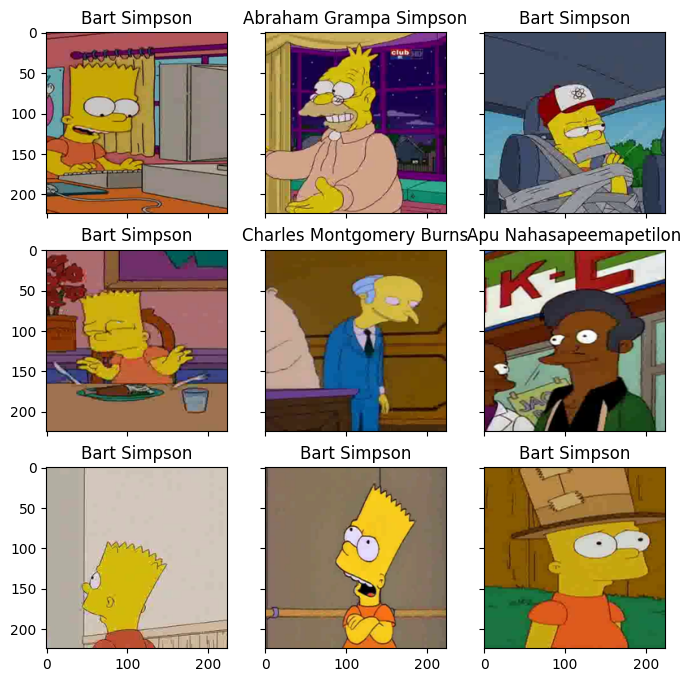

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [14]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [21]:
BATCH_SIZE = 128

In [22]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.8527813684910726


epoch:  50%|█████     | 1/2 [04:28<04:28, 268.52s/it]


Epoch 001 train_loss: 2.8528     val_loss 2.3134 train_acc 0.1956 val_acc 0.3619
loss 1.916580657775527


epoch: 100%|██████████| 2/2 [06:53<00:00, 206.90s/it]


Epoch 002 train_loss: 1.9166     val_loss 1.6535 train_acc 0.4764 val_acc 0.5577


Построим кривые обучения

In [23]:
loss, acc, val_loss, val_acc = zip(*history)

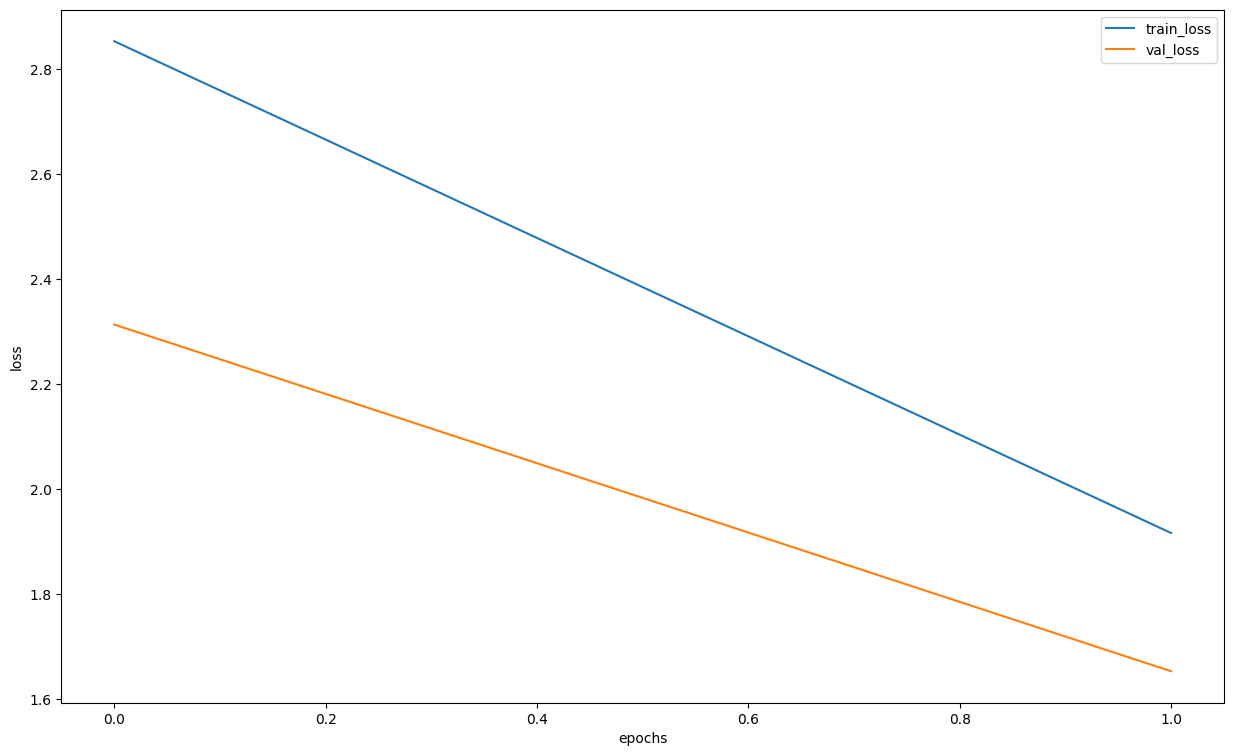

In [24]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [25]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [26]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [27]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [28]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [29]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [30]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.25


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

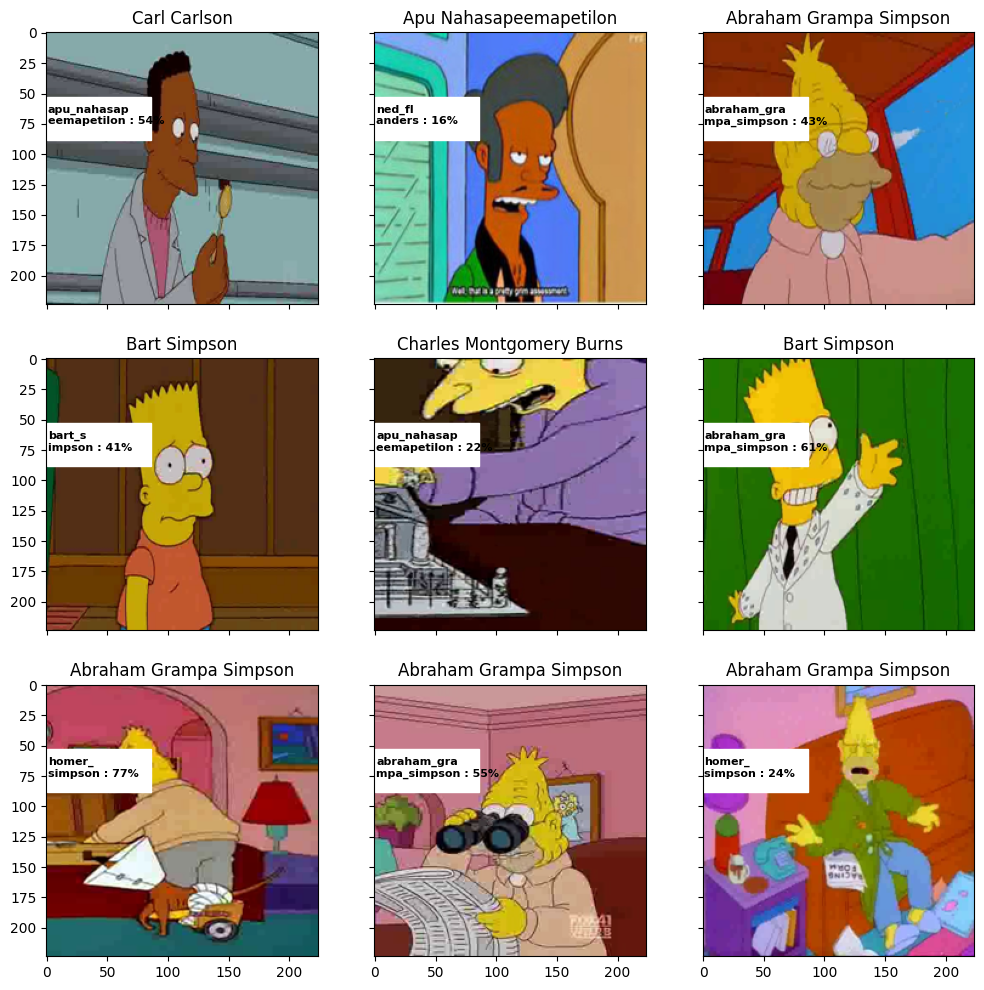

In [31]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [32]:

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [33]:
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_filenames = [path.name for path in test_dataset.files]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

def get_submission(model, submit_name, test_loader, batch_size = BATCH_SIZE):

    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    submit.to_csv(f'{submit_name}.csv', index=False)

    return submit, f'{submit_name}.csv'

In [34]:
data, sub_name = get_submission(simple_cnn, 'simble_cnn_submission', test_loader)
data

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,lisa_simpson
987,img988.jpg,sideshow_bob
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


### Немного модифицируем CNN:
- добавим BatchNorm2d
- добавим dropout'ы
- avgpool


In [35]:
class NextCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.out = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(96 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

### Модифицируем SimpsonsDataset, чтобы добавить аугментацию данных


In [36]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
      
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            self.transform = transform

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
      
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [37]:
from torchvision import transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE), antialias=True),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

train_dataset = SimpsonsDataset(train_files, mode='train', transform = transform)
val_dataset = SimpsonsDataset(val_files, mode='val', transform = transform)

### Добавим learning rate scheduler
- Для этого модифицируем немного метод train

In [38]:
from torch.optim import lr_scheduler

def train(train_files, val_files, model, epochs, batch_size, lr_step_size = 2, lr_gamma = 0.5, start_lr=3e-4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} lr_rate: {lr_rate:0.7f} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=start_lr)
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size = lr_step_size, gamma = lr_gamma)

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, lr_rate=opt.param_groups[-1]['lr']))
            scheduler.step()

    return history

In [39]:
next_cnn = NextCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(next_cnn)

we will classify :42
NextCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3)

Не хватает времени до дедлайна. снизил до 2х эпох при публикации (f1 >= .85 на >20 эпох):

In [40]:
next_cnn_history = train(train_dataset, val_dataset, model=next_cnn, epochs=2, batch_size=BATCH_SIZE, start_lr=1e-3, lr_step_size=3, lr_gamma=0.5)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 3.208310411040043


epoch:  50%|█████     | 1/2 [04:34<04:34, 274.49s/it]


Epoch 001 lr_rate: 0.0010000 train_loss: 3.2083     val_loss: 2.4782 train_acc: 0.1708 val_acc: 0.2889
loss 2.3040761374327716


epoch: 100%|██████████| 2/2 [08:55<00:00, 267.86s/it]


Epoch 002 lr_rate: 0.0010000 train_loss: 2.3041     val_loss: 1.7863 train_acc: 0.3507 val_acc: 0.4941


In [41]:
def show_train_loss_graph(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

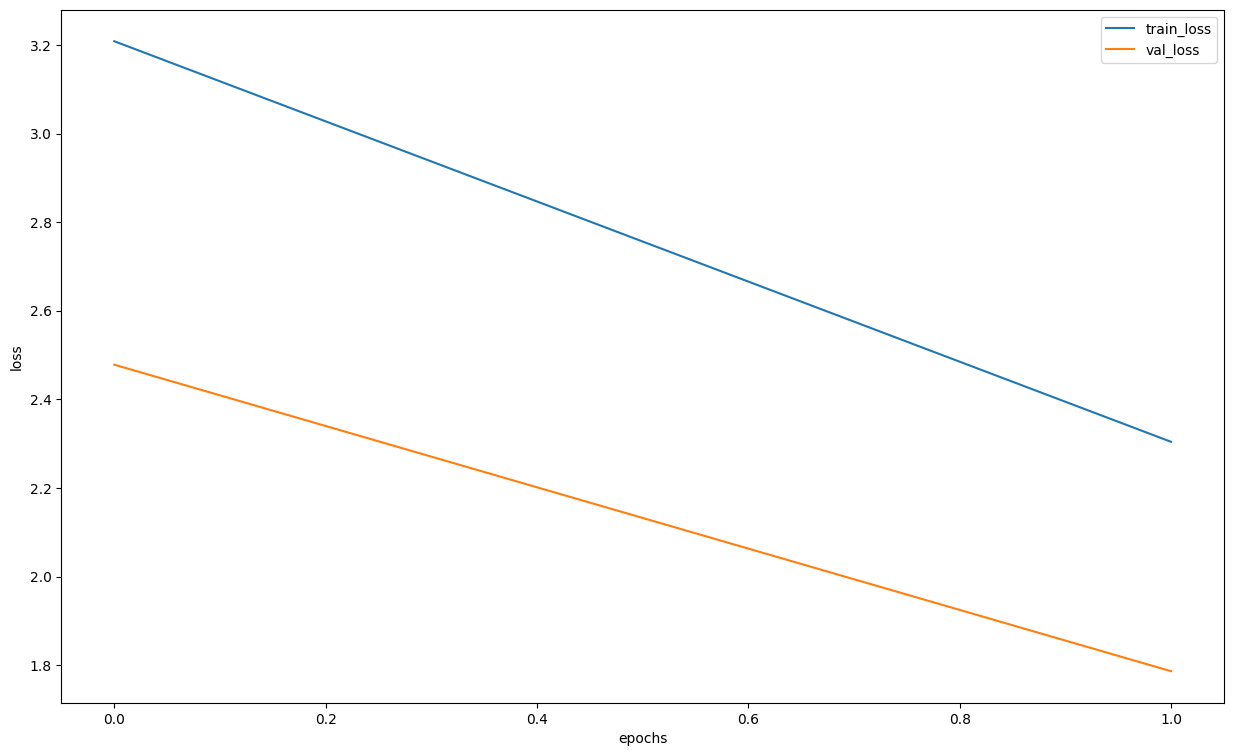

In [42]:
show_train_loss_graph(next_cnn_history)

In [43]:

def show_score(model, val_dataset):
    idxs = list(map(int, np.random.uniform(0,1000, 100)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [label_encoder.inverse_transform([val_dataset[id][1]]).item() for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]
    
    f1 = f1_score(actual_labels, preds_class, average='micro')

    print("F1-оценка:", f1)

In [44]:
show_score(next_cnn, val_dataset)

F1-оценка: 0.15


In [45]:
next_cnn_sub, sub_name = get_submission(next_cnn, 'next_cnn_submission', test_loader)
next_cnn_sub

,Id,Expected
0,img0.jpg,ned_flanders
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,principal_skinner
987,img988.jpg,sideshow_bob
988,img989.jpg,principal_skinner
989,img99.jpg,chief_wiggum


### ResNet18

In [46]:
resnet_model = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


In [47]:
resnet_model.fc = nn.Linear(512, n_classes)

n_classes = len(np.unique(train_val_labels))
resnet_model = resnet_model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(resnet_model)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

### Модифицируем параметры модели

In [48]:
def train(train_files, val_files, model, epochs, batch_size, lr_step_size = 2, lr_gamma = 0.5, start_lr=3e-4, params = None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} lr_rate: {lr_rate:0.7f} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f}"

    if not params:
        params = model.parameters()

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params, lr=start_lr)
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size = lr_step_size, gamma = lr_gamma)

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, lr_rate=opt.param_groups[-1]['lr']))
            scheduler.step()

    return history

In [49]:
params = [
    {"params": resnet_model.fc.parameters()},
    {"params": resnet_model.layer1.parameters(), "lr": 1e-5,},
    {"params": resnet_model.layer2.parameters(), "lr": 1e-5,},
    {"params": resnet_model.layer3.parameters(), "lr": 1e-5,},
    {"params": resnet_model.layer4.parameters(), "lr": 1e-5,},
]

In [50]:
resnet_history = train(train_dataset, val_dataset, model=resnet_model,\
                       epochs=20, batch_size=BATCH_SIZE, start_lr=1e-4, lr_step_size=4, lr_gamma=0.5, params=params)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.929961386057395


epoch:   5%|▌         | 1/20 [04:37<1:27:44, 277.09s/it]


Epoch 001 lr_rate: 0.0000100 train_loss: 2.9300     val_loss: 2.3252 train_acc: 0.2305 val_acc: 0.4412
loss 1.3387242452955086


epoch:  10%|█         | 2/20 [09:14<1:23:07, 277.11s/it]


Epoch 002 lr_rate: 0.0000100 train_loss: 1.3387     val_loss: 0.8318 train_acc: 0.6819 val_acc: 0.8059
loss 0.7521886305829067


epoch:  15%|█▌        | 3/20 [13:57<1:19:16, 279.80s/it]


Epoch 003 lr_rate: 0.0000100 train_loss: 0.7522     val_loss: 0.6102 train_acc: 0.8090 val_acc: 0.8485
loss 0.5746365536894872


epoch:  20%|██        | 4/20 [18:47<1:15:42, 283.89s/it]


Epoch 004 lr_rate: 0.0000100 train_loss: 0.5746     val_loss: 0.5047 train_acc: 0.8481 val_acc: 0.8687
loss 0.4646842070818479


epoch:  25%|██▌       | 5/20 [23:28<1:10:44, 282.96s/it]


Epoch 005 lr_rate: 0.0000050 train_loss: 0.4647     val_loss: 0.4331 train_acc: 0.8769 val_acc: 0.8848
loss 0.42238327254686503


epoch:  30%|███       | 6/20 [28:14<1:06:16, 284.02s/it]


Epoch 006 lr_rate: 0.0000050 train_loss: 0.4224     val_loss: 0.4156 train_acc: 0.8867 val_acc: 0.8957
loss 0.39040979313974933


epoch:  35%|███▌      | 7/20 [32:54<1:01:14, 282.68s/it]


Epoch 007 lr_rate: 0.0000050 train_loss: 0.3904     val_loss: 0.3912 train_acc: 0.8950 val_acc: 0.8985
loss 0.3670677256850697


epoch:  40%|████      | 8/20 [37:36<56:29, 282.45s/it]


Epoch 008 lr_rate: 0.0000050 train_loss: 0.3671     val_loss: 0.3733 train_acc: 0.9022 val_acc: 0.9016
loss 0.3307818631154579


epoch:  45%|████▌     | 9/20 [42:15<51:34, 281.33s/it]


Epoch 009 lr_rate: 0.0000025 train_loss: 0.3308     val_loss: 0.3649 train_acc: 0.9116 val_acc: 0.9049
loss 0.31057720109454934


epoch:  50%|█████     | 10/20 [46:52<46:40, 280.02s/it]


Epoch 010 lr_rate: 0.0000025 train_loss: 0.3106     val_loss: 0.3586 train_acc: 0.9144 val_acc: 0.9083
loss 0.31031868201553825


epoch:  55%|█████▌    | 11/20 [51:32<41:59, 279.94s/it]


Epoch 011 lr_rate: 0.0000025 train_loss: 0.3103     val_loss: 0.3563 train_acc: 0.9171 val_acc: 0.9071
loss 0.299922228261949


epoch:  60%|██████    | 12/20 [56:08<37:11, 278.89s/it]


Epoch 012 lr_rate: 0.0000025 train_loss: 0.2999     val_loss: 0.3423 train_acc: 0.9183 val_acc: 0.9127
loss 0.2908039219144484


epoch:  65%|██████▌   | 13/20 [1:00:50<32:38, 279.76s/it]


Epoch 013 lr_rate: 0.0000013 train_loss: 0.2908     val_loss: 0.3365 train_acc: 0.9207 val_acc: 0.9152
loss 0.27285273058853815


epoch:  70%|███████   | 14/20 [1:05:30<27:59, 279.84s/it]


Epoch 014 lr_rate: 0.0000013 train_loss: 0.2729     val_loss: 0.3330 train_acc: 0.9257 val_acc: 0.9159
loss 0.27701783988557654


epoch:  75%|███████▌  | 15/20 [1:10:07<23:14, 278.98s/it]


Epoch 015 lr_rate: 0.0000013 train_loss: 0.2770     val_loss: 0.3318 train_acc: 0.9248 val_acc: 0.9177
loss 0.2676128479422821


epoch:  80%|████████  | 16/20 [1:14:43<18:32, 278.19s/it]


Epoch 016 lr_rate: 0.0000013 train_loss: 0.2676     val_loss: 0.3310 train_acc: 0.9274 val_acc: 0.9173
loss 0.261884531264275


epoch:  85%|████████▌ | 17/20 [1:19:21<13:54, 278.10s/it]


Epoch 017 lr_rate: 0.0000006 train_loss: 0.2619     val_loss: 0.3269 train_acc: 0.9306 val_acc: 0.9198
loss 0.2656377893613018


epoch:  90%|█████████ | 18/20 [1:24:06<09:20, 280.03s/it]


Epoch 018 lr_rate: 0.0000006 train_loss: 0.2656     val_loss: 0.3246 train_acc: 0.9278 val_acc: 0.9211
loss 0.2579981644914153


epoch:  95%|█████████▌| 19/20 [1:28:46<04:40, 280.04s/it]


Epoch 019 lr_rate: 0.0000006 train_loss: 0.2580     val_loss: 0.3259 train_acc: 0.9328 val_acc: 0.9203
loss 0.2674956499231766


epoch: 100%|██████████| 20/20 [1:33:32<00:00, 280.64s/it]


Epoch 020 lr_rate: 0.0000006 train_loss: 0.2675     val_loss: 0.3196 train_acc: 0.9270 val_acc: 0.9211


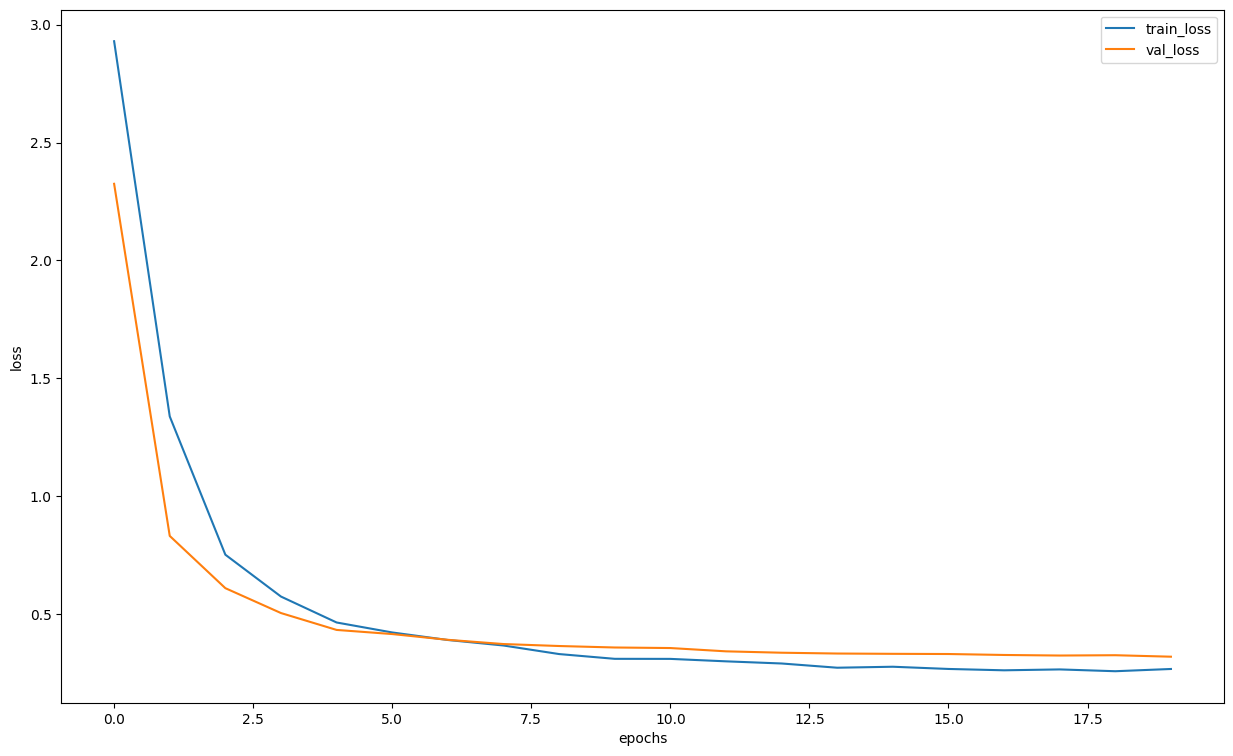

In [51]:
show_train_loss_graph(resnet_history)

In [52]:
show_score(resnet_model, val_dataset)

F1-оценка: 0.98


In [53]:
resnet_sub, _ = get_submission(resnet_model, 'resnet_submission', test_loader)
resnet_sub

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [54]:
best_submission = resnet_sub
best_submission.to_csv('submission.csv', index=False)